In [24]:
import geopandas as gpd
import pandas as pd
import numpy as np
import shapely.geometry as geo
import matplotlib.pyplot as plt
import zipfile, os
%matplotlib inline

In [ ]:
# Data needed:
# - data/GPE_GARE_LOCALISATION : unpacked stop data from Societé de Grand Paris
# - data/IDFM-gtfs.zip : GTFS schedule from Ile-de-France mobilités

## Some settings

In [25]:
frequency = 20 * 60 # Every 20 minutes
speed = 40 # km/h

## Load stop data

In [26]:
# Needs to be unpacked first
df_data = gpd.read_file("data/GPE_GARE_LOCALISATION/GPE_GARE_LOCALISATION.shp")
df_data = df_data[df_data["LIGNE"].str.contains("L18")].copy()

## Generate stops

In [27]:
df_stops = df_data.copy().to_crs("EPSG:4326")
df_stops["stop_id"] = np.arange(len(df_stops))
df_stops["stop_id"] = "gpe:18:" + df_stops["stop_id"].astype(str)
df_stops["stop_lon"] = df_stops["geometry"].x
df_stops["stop_lat"] = df_stops["geometry"].y
df_stops["location_type"] = 0
df_stops["stop_name"] = df_stops["LIBELLE"]
df_stops = df_stops.sort_values(by = "CODE")

df_stops = df_stops[[
    "stop_id", "stop_name", "location_type", "stop_lon", "stop_lat", "geometry"]] # Keeping geometry for stop times 

## Generate agency

In [28]:
df_agency = pd.DataFrame({
    "agency_id": ["gpe"], # Let's create a new agency to have a clean setup
    "agency_name": ["GPE"],
    "agency_url": ["unknown"],
    "agency_timezone": ["Europe/Paris"]
})

## Generate routes

In [29]:
df_routes = pd.DataFrame({
    "route_id": ["gpe:18"], # We only have one route here, which is line 18
    "agency_id": ["gpe"],
    "route_type": 1, # Subway
    "route_long_name": "GPE 18" # Requires by OpenTripPlanner
})

In [30]:
df_routes

,route_id,agency_id,route_type,route_long_name
0,gpe:18,gpe,1,GPE 18


## Generate Calendar

In [31]:
df_calendar = pd.DataFrame({
    # We want this service to run on all days, we don't create specific configurations
    # And generating a calendar entry is easier than resusing one from the existing GTFS data
    "service_id": ["gpe"],
    "monday": [1],
    "tuesday": [1],
    "wednesday": [1],
    "thursday": [1],
    "friday": [1],
    "saturday": [1],
    "sunday": [1],
    "start_date": ["20200101"],
    "end_date": ["20300101"]
})

## Generate Trips

In [32]:
df_trips = []

for direction in ("fw", "bw"): # Forward and backward
    for departure in range(0, int(24 * 3600 / frequency)):
        df_trips.append({
            "trip_id": "gpe:18:{}:{}".format(direction, departure),
            "route_id": "gpe:18",
            "service_id": "gpe", # From the calendar
            "direction": direction, # Used to generate stop times later
            "departure_time": frequency * departure # Used to generate stop times later
        })

df_trips = pd.DataFrame.from_records(df_trips)

In [33]:
df_trips

,trip_id,route_id,service_id,direction,departure_time
0,gpe:18:fw:0,gpe:18,gpe,fw,0
1,gpe:18:fw:1,gpe:18,gpe,fw,1200
2,gpe:18:fw:2,gpe:18,gpe,fw,2400
3,gpe:18:fw:3,gpe:18,gpe,fw,3600
4,gpe:18:fw:4,gpe:18,gpe,fw,4800
...,...,...,...,...,...
139,gpe:18:bw:67,gpe:18,gpe,bw,80400
140,gpe:18:bw:68,gpe:18,gpe,bw,81600
141,gpe:18:bw:69,gpe:18,gpe,bw,82800
142,gpe:18:bw:70,gpe:18,gpe,bw,84000


## Generate stop times

In [34]:
df_locations = df_stops[["geometry"]].to_crs("EPSG:2154")
locations = np.array([df_locations["geometry"].x, df_locations["geometry"].y]).T

distances = np.array([
    np.sqrt(np.sum((locations[k] - locations[k-1])**2))
    for k in range(1, len(locations))
])

travel_times = (distances * 1e-3 / speed) * 3600 # in seconds

In [35]:
df_stop_times = []

for index, trip in df_trips.iterrows():
    df_times = df_stops[["stop_id"]].copy()
    
    if trip["direction"] == "bw": # Consider opposite order in backwards trajectory
        df_times = df_times.iloc[::-1]
        
    times = np.array([0.0] + list(travel_times))  
    
    df_times["departure_time"] = trip["departure_time"] + np.cumsum(times)
    df_times["arrival_time"] = trip["departure_time"] + np.cumsum(times)
    df_times["trip_id"] = trip["trip_id"]
    df_times["stop_sequence"] = np.arange(len(df_times))
    
    df_stop_times.append(df_times)
    
df_stop_times = pd.concat(df_stop_times)

In [36]:
def format_time(time): # Transform seconds in HH:MM:SS
    hours = int(time // 3600)
    minutes = int((time - hours * 3600) // 60)
    seconds = int(time - hours * 3600 - minutes * 60)
    return "{:02}:{:02}:{:02}".format(hours, minutes, seconds)

df_stop_times["departure_time"] = df_stop_times["departure_time"].apply(format_time)
df_stop_times["arrival_time"] = df_stop_times["arrival_time"].apply(format_time)

In [37]:
df_stop_times

,stop_id,departure_time,arrival_time,trip_id,stop_sequence
21,gpe:18:4,00:00:00,00:00:00,gpe:18:fw:0,0
31,gpe:18:8,00:05:56,00:05:56,gpe:18:fw:0,1
30,gpe:18:7,00:08:09,00:08:09,gpe:18:fw:0,2
15,gpe:18:2,00:11:52,00:11:52,gpe:18:fw:0,3
9,gpe:18:1,00:18:25,00:18:25,gpe:18:fw:0,4
...,...,...,...,...,...
9,gpe:18:1,24:01:31,24:01:31,gpe:18:bw:71,5
15,gpe:18:2,24:04:46,24:04:46,gpe:18:bw:71,6
30,gpe:18:7,24:15:51,24:15:51,gpe:18:bw:71,7
31,gpe:18:8,24:21:36,24:21:36,gpe:18:bw:71,8


## Cleanup

In [38]:
df_stops = df_stops[["stop_id", "stop_name", "location_type", "stop_lon", "stop_lat"]]

In [39]:
df_trips = df_trips[["trip_id", "route_id", "service_id"]]

In [40]:
df_stop_times = df_stop_times[["trip_id", "arrival_time", "departure_time", "stop_id", "stop_sequence"]]

## Drawing the line

In [41]:
df_points = df_stops.copy()
df_points["geometry"] = [geo.Point(x,y) for x, y in zip(df_points["stop_lon"], df_points["stop_lat"])]
df_points = gpd.GeoDataFrame(df_points[["stop_id", "stop_name", "geometry"]], crs = "EPSG:4326")

In [42]:
df_line = gpd.GeoDataFrame(pd.DataFrame({
    "id": ["gpe:18"],
    "geometry": geo.LineString(df_points["geometry"])
}), crs = "EPSG:4326")

<AxesSubplot: >

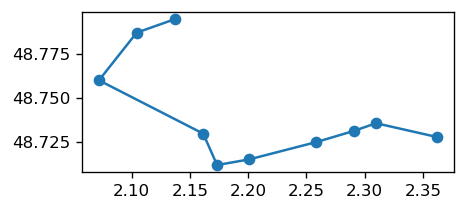

In [43]:
plt.figure(dpi = 120, figsize = (4, 4))
df_points.plot(ax = plt.gca())
df_line.plot(ax = plt.gca())

## Drawing in QGIS

In [44]:
df_points.to_file("points.gpkg")
df_line.to_file("line.gpkg")

![QGIS](images/qgis.png)

## Generate a standalone GTFS for testing

In [45]:
with zipfile.ZipFile("standalone-gtfs.zip", "w") as archive:
    # Agency
    df_agency.to_csv(archive.open("agency.txt", "w"), index = False)

    # Calendar
    df_calendar.to_csv(archive.open("calendar.txt", "w"), index = False)

    # Routes
    df_routes.to_csv(archive.open("routes.txt", "w"), index = False)

    # Stops
    df_stops.to_csv(archive.open("stops.txt", "w"), index = False)

    # Trips
    df_trips.to_csv(archive.open("trips.txt", "w"), index = False)

    # Stop times
    df_stop_times.to_csv(archive.open("stop_times.txt", "w"), index = False)

This can be tested using OpenTripPlanner:

![OTP](images/otp_testing.png)

## Generate new GTFS based on IDFM

In [46]:
# We create it by copying (and modifying) the files of the original GTFS into a new one
with zipfile.ZipFile("data/IDFM-gtfs.zip") as origin:
    with zipfile.ZipFile("updated-gtfs.zip", "w") as destination:
        # Agency
        df_origin = pd.read_csv(origin.open("agency.txt"))
        df = pd.concat([df_origin, df_agency])
        df.to_csv(destination.open("agency.txt", "w"), index = False)

        # Calendar
        df_origin = pd.read_csv(origin.open("calendar.txt"))
        df = pd.concat([df_origin, df_calendar])
        df.to_csv(destination.open("calendar.txt", "w"), index = False)

        # Routes
        df_origin = pd.read_csv(origin.open("routes.txt"))
        df = pd.concat([df_origin, df_routes])
        df.to_csv(destination.open("routes.txt", "w"), index = False)

        # Stops
        df_origin = pd.read_csv(origin.open("stops.txt"))
        df = pd.concat([df_origin, df_stops])
        df.to_csv(destination.open("stops.txt", "w"), index = False)

        # Trips
        df_origin = pd.read_csv(origin.open("trips.txt"))
        df = pd.concat([df_origin, df_trips])
        df.to_csv(destination.open("trips.txt", "w"), index = False)

        # Stop times
        df_origin = pd.read_csv(origin.open("stop_times.txt"))
        df = pd.concat([df_origin, df_stop_times])
        df.to_csv(destination.open("stop_times.txt", "w"), index = False)

        # Copy remaining files
        for name in ("pathways.txt", "calendar_dates.txt", "stop_extensions.txt", "transfers.txt"):
            df_origin = pd.read_csv(origin.open(name))
            df_origin.to_csv(destination.open(name, "w"), index = False)

/tmp/ipykernel_5179/2247487373.py:25: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_origin = pd.read_csv(origin.open("trips.txt"))


Test with OpenTripPlanner and and itineraries that makes first use of RER B and then switches to GPE 18:

![OTP](images/example_idfm.png)